In [0]:
!pip install kaggle

In [0]:
#code pour utiliser kaggle api dans codelab, et telecharger les donne dans le serveur
#suivre les etapes dans le lien:
#https://medium.com/@move37timm/using-kaggle-api-for-google-colaboratory-d18645f93648
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions download -c ift3395-6390-f2018
!unzip -n train_images.npy.zip
!unzip -n test_images.npy.zip

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train_labels.csv: Skipping, found more recently modified local copy (use --force to force download)
test_images.npy.zip: Skipping, found more recently modified local copy (use --force to force download)
train_images.npy.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train_images.npy.zip
Archive:  test_images.npy.zip


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'




In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
#Load images with numpy
def randomize(a, b):
    #pris de:https://tech.pic-collage.com/tips-of-numpy-shuffle-multiple-arrays-e4fb3e7ae2a
    # Generate the permutation index array.
    permutation = np.random.permutation(a.shape[0])
    # Shuffle the arrays by giving the permutation in the square brackets.
    shuffled_a = a[permutation]
    shuffled_b = b[permutation]
    return shuffled_a, shuffled_b
import torch
%pylab inline
images_train_raw = np.load('train_images.npy', encoding='latin1')
train_labels_raw = np.genfromtxt('train_labels.csv', names=True, delimiter=',', dtype=[('Id', 'i8'), ('Category', 'S5')])

#images_train_raw,train_labels_raw=randomize((images_train_raw),(train_labels_raw))



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['entropy', 'flatten', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
# cette partie converti les donnes en tensor pour torch
#cette partie remplie la ram tres rapidement
#a ameliorer'
from collections import Counter
from scipy import ndimage
from skimage.filters.rank import entropy
from skimage.morphology import disk
torch.set_default_tensor_type('torch.DoubleTensor')
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
x_train =images_train_raw[:,1]
y_train =train_labels_raw
import cv2
import math


num_classes=31
def class_to_num(string):
    words=['sink','pear','moust','nose','skate','pengu','peanu','skull','panda','paint','nail','apple','rifle','mug','sailb','pinea','spoon','rabbi','shove','rolle','screw','scorp','rhino','pool','octag','pillo','parro','squig','mouth','empty','penci']
    return words.index(string.decode('UTF-8'))
def num_to_class(num):
    words=['sink','pear','moustache','nose','skateboard','penguin','peanut','skull','panda','paintbrush','nail','apple','rifle','mug','sailboat','pineapple','spoon','rabbit','shovel','rollerskates','screwdriver','scorpion','rhinoceros','pool','octagon','pillow','parrot','squiggle','mouth','empty','pencil',]
    return words[int(num)]
def cookie_cutter(center_coo,img,step):
    img_dim=img.shape[0]
    #cette partie prend le centre d'entropie et coupe un caree autour:
    coo1=min(img_dim-step*2,max(0,center_coo[0]-step))
    coo2=max(step*2 ,min(100,center_coo[0]+step))
    coo3=min(img_dim-step*2,max(0,center_coo[1]-step))
    coo4=max(step*2 ,min(100,center_coo[1]+step))
    image_cut=img[coo1:coo2,coo3:coo4]
    return image_cut
def entropy_cut(img):
    #from skimage.filters.rank import entropy
    #from skimage.morphology import disk
    temp=np.uint8(img)#converti en int pour la fn entropy() , mais le centre de l'image original est utilisee
    cann = cv2.bilateralFilter(temp,9,100,100)
    #temp_img=np.where(img > 40, 1, 0)
    ent=entropy(cann,disk(10))
    indx_1d =np.argmax(ent)
    ent_center=np.unravel_index(indx_1d, (100,100))#coordonnes du centre d'enropie
    cut=cookie_cutter(ent_center,img,20)
    return cut
def centroid_cut(img):
    
    center=ndimage.measurements.center_of_mass(img)
    
    cut=cookie_cutter((math.floor(center[0]),math.floor(center[1])),img,16)
    return cut
def uber_cut(img):
    temp=np.where(img > 40, 1, 0)
    num,contour=cv2.connectedComponents(np.uint8(temp))
    s_countours=np.array(contour).reshape((100,100))
    sec_common=Counter(s_countours.flatten()).most_common(2)[1][0]
    
    
    s_countours_max=np.where(s_countours== (sec_common), 1, 0)
    
    filled_contour_max=ndimage.morphology.binary_fill_holes(s_countours_max)
    
    #isolated_img= np.multiply(img+(np.ones((100,100))*50) , filled_contour_max)#version avec coloriage
    isolated_img= np.multiply(img , filled_contour_max)
    return centroid_cut(isolated_img)

num_train=x_train.shape[0]

inputX=[]
labelY=[]
for i in range(y_train.shape[0]):
    labelY.append(  class_to_num( y_train[i][1] ) )
    #print( y_train[i][1],class_to_num( y_train[i][1] ))
for i in range(x_train.shape[0]):
    temp=uber_cut(x_train[i].reshape(100,100)).flatten()
    #temp=x_train[i]
    inputX.append( np.array(temp.tolist()))#.reshape(1,100,100)


from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(n_values=num_classes, sparse=False)
#y_train = one_hot.fit_transform(np.array([labelY]).reshape(-1,1))
#y_test = one_hot.transform(np.array([labelPrimeY]).reshape(-1,1))





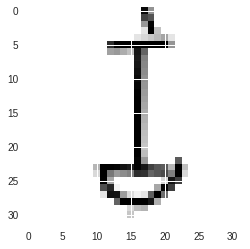

(0, b'shove')


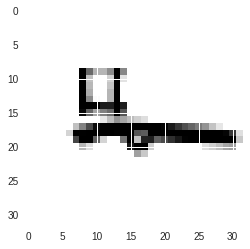

(1, b'rifle')


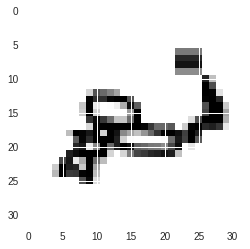

(2, b'scorp')


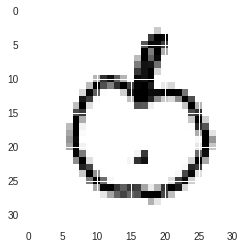

(3, b'apple')


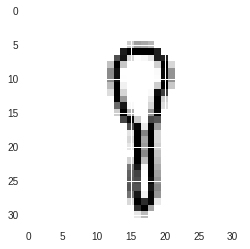

(4, b'spoon')


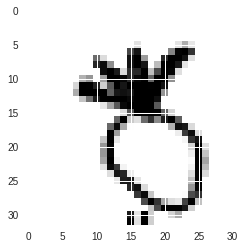

(5, b'pinea')


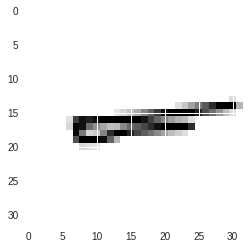

(6, b'rifle')


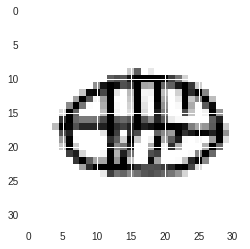

(7, b'mouth')


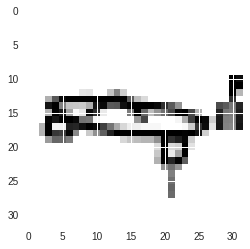

(8, b'skate')


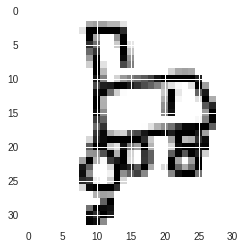

(9, b'rolle')


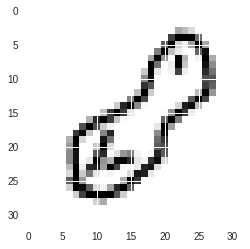

(10, b'peanu')


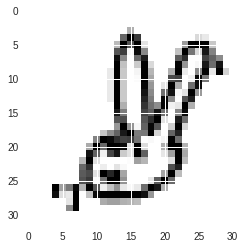

(11, b'rabbi')


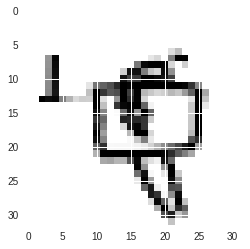

(12, b'sink')


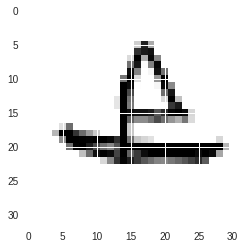

(13, b'sailb')


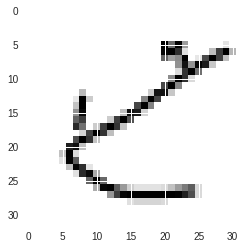

(14, b'nose')


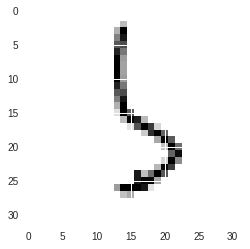

(15, b'nose')


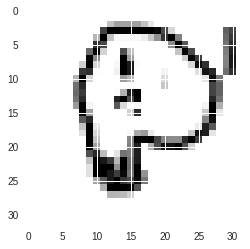

(16, b'skull')


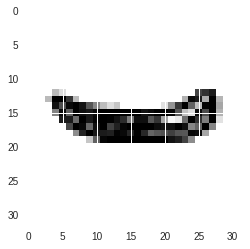

(17, b'mouth')


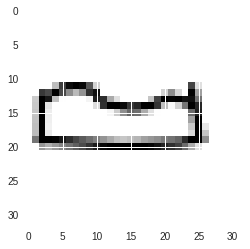

(18, b'pool')


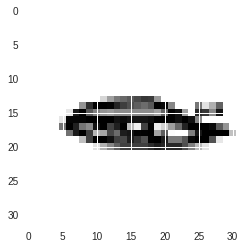

(19, b'mouth')


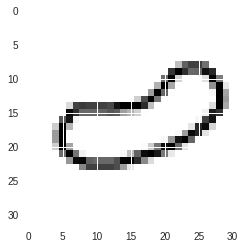

(20, b'peanu')


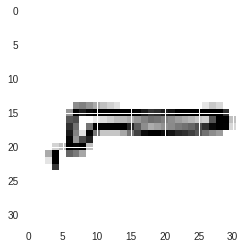

(21, b'rifle')


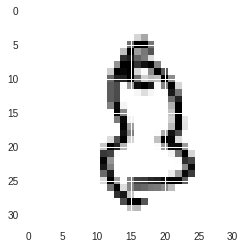

(22, b'pear')


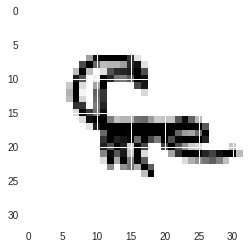

(23, b'scorp')


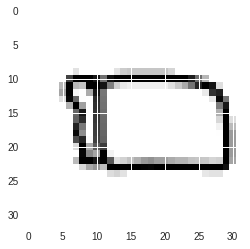

(24, b'pillo')


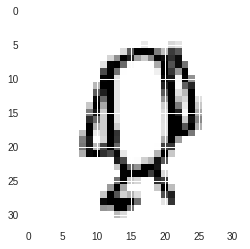

(25, b'pengu')


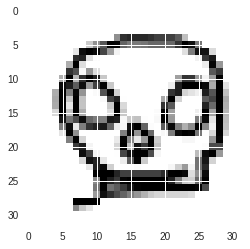

(26, b'skull')


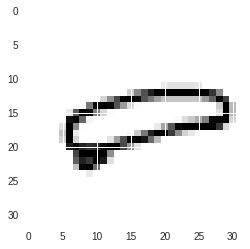

(27, b'skate')


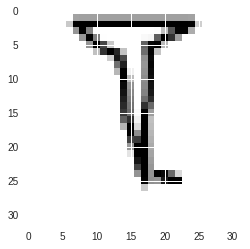

(28, b'nail')


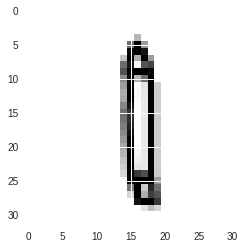

(29, b'penci')


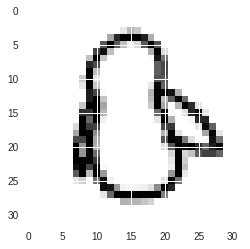

(30, b'pengu')


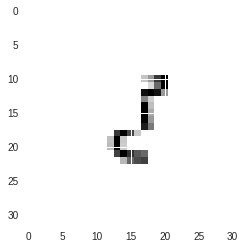

(31, b'empty')


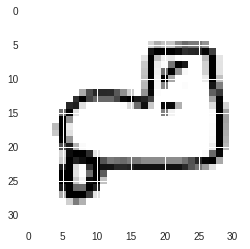

(32, b'rolle')


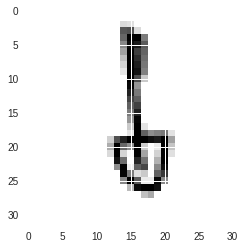

(33, b'shove')


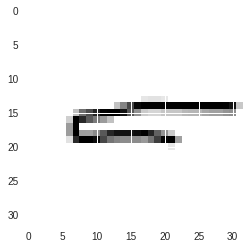

(34, b'rifle')


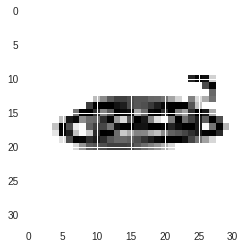

(35, b'pool')


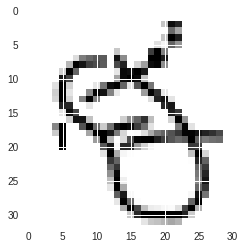

(36, b'peanu')


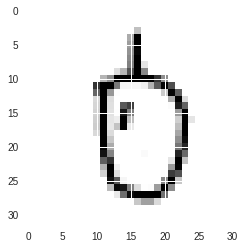

(37, b'pear')


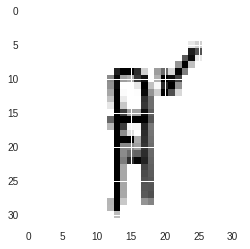

(38, b'nail')


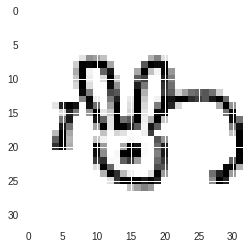

(39, b'rabbi')


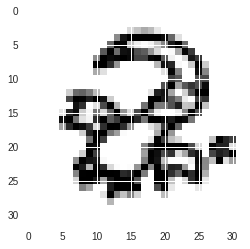

(40, b'scorp')


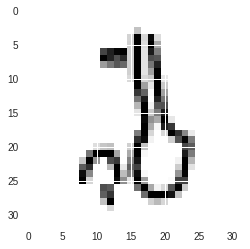

(41, b'spoon')


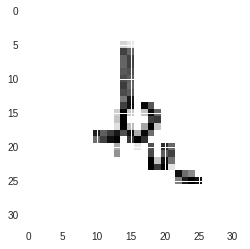

(42, b'spoon')


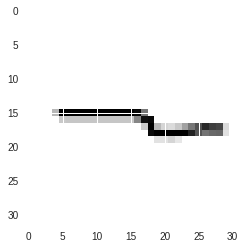

(43, b'rifle')


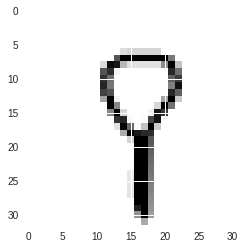

(44, b'spoon')


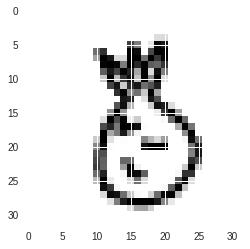

(45, b'pinea')


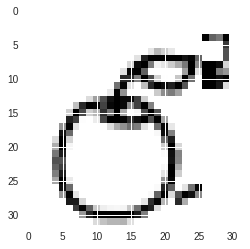

(46, b'apple')


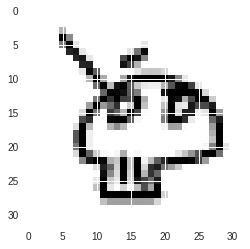

(47, b'skull')


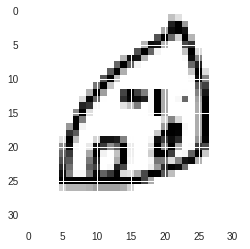

(48, b'nose')


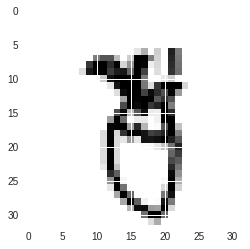

(49, b'pinea')


In [0]:
#pour voir si le reperage des dessins et decoupage se passe bien:
for i in range(50):
    image_ = inputX[i].reshape(32,32)
    plt.imshow(image_)
    plt.show() 
    print(train_labels_raw[i])

In [0]:
import torch
from torch.utils import data
import torchvision.transforms as transforms
class myDataset(data.Dataset):

  def __init__(self, X, y,transf):
        self.transf=transf
        self.y = y
        self.X = X#.reshape(-1, 1, 32, 32)
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
            
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

  def __len__(self):

        return len(self.y)

  def __getitem__(self, index):
        # Load data and get label
        X = self.X
        y = self.y

        return (X[index], y[index])


In [0]:
"""
ZONE TEST
pris de https://conorsdatablog.wordpress.com/2018/05/03/up-and-running-with-pytorch-minibatching-dataloading-and-model-building/
from torchvision import datasets, transforms
params = {'batch_size': 64,
          'shuffle': False}

train_generator = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
   **params)
for batch_idx, (data, target) in enumerate(train_generator):
    print("id ",batch_idx)
    print("data ",data)
    print("target ",target)
"""

'\nZONE TEST\npris de https://conorsdatablog.wordpress.com/2018/05/03/up-and-running-with-pytorch-minibatching-dataloading-and-model-building/\nfrom torchvision import datasets, transforms\nparams = {\'batch_size\': 64,\n          \'shuffle\': False}\n\ntrain_generator = torch.utils.data.DataLoader(\n    datasets.MNIST(\'../data\', train=True, download=True,\n                   transform=transforms.Compose([\n                       transforms.ToTensor(),\n                       transforms.Normalize((0.1307,), (0.3081,))\n                   ])),\n   **params)\nfor batch_idx, (data, target) in enumerate(train_generator):\n    print("id ",batch_idx)\n    print("data ",data)\n    print("target ",target)\n'

In [0]:
"""
#ZONE TEST
train_loader=myDataset(x_train,y_train)
params = {'batch_size':2,
          'shuffle': False}

train_generator =  torch.utils.data.DataLoader(train_loader, **params)
for batch_idx, (data, target) in enumerate(train_generator):
    print("id ",batch_idx)
    print("data ",data)
    print("target ",target)
    print("shape", data.shape)
"""

'\n#ZONE TEST\ntrain_loader=myDataset(x_train,y_train)\nparams = {\'batch_size\':2,\n          \'shuffle\': False}\n\ntrain_generator =  torch.utils.data.DataLoader(train_loader, **params)\nfor batch_idx, (data, target) in enumerate(train_generator):\n    print("id ",batch_idx)\n    print("data ",data)\n    print("target ",target)\n    print("shape", data.shape)\n'

In [0]:
import torch
torch.cuda.device_count()

1

In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(32*32, 700)
        
       
        self.fcF = nn.Linear(700, 31)
    def forward(self, x):
               
        out = x.view(-1, x.size(1))
        out = F.relu((self.fc1(out)))
        out = self.fcF(out)
        return out


def train(model, device, train_loader, optimizer, epoch, loss_fn):
    #fonction pris de la demo 10
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model((data))
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10== 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())) 
def test(model, device, test_loader, loss_fn):
    #fonction pris de la demo 10
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model((data))
            test_loss += loss_fn(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return ( correct / len(test_loader.dataset))

def predict(model, device, test_loader):
    model.eval()
    list_predictions=[]
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model((data))
            pred = output.max(1, keepdim=False)[1]
            list_predictions.append(pred)
    return list_predictions
# HYPERPARAMETERS TO PLAY WITH

# device = torch.device("cpu")

learning_rate = 0.0001
epochs =100

from sklearn.model_selection import StratifiedKFold
params = {'batch_size':32,
              'shuffle': True}
paramsTest = {'batch_size': 512,
              'shuffle': False}


device = torch.device('cuda')


In [0]:



def adjust_lr(optimizer, epoch):
    
    lr = learning_rate * (0.2 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
def train_test_model(train_index, test_index):
    
    
    x_train = torch.from_numpy(np.array(inputX)[train_index]).to(device)
    x_test = torch.from_numpy(np.array(inputX)[test_index]).to(device)
    
    y_train = torch.from_numpy(np.array(labelY)[train_index] ).to(device)
    y_test = torch.from_numpy(np.array(labelY)[test_index] ).to(device)
    
    from sklearn.utils import class_weight
    #cette variable contient les poids pour blancer les classes
    class_wg=class_weight.compute_class_weight('balanced',np.arange(31), np.array(labelY)[train_index])
    class_wg_tensor=torch.from_numpy(np.array(class_wg)).to(device)
    
    
    model =MLPNet().to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)



    loss_fn = nn.CrossEntropyLoss(weight=class_wg_tensor)
    test_loss_fn = nn.CrossEntropyLoss(reduction='sum')


    # data loading
    
    train_loader=myDataset(x_train,y_train,transforms.Compose([        
        transforms.ToPILImage(),
        transforms.RandomRotation((-20,20)),
        transforms.RandomAffine(0,scale=(0.87,1.1),shear=(-8,8)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.5,],std=[0.5,]) 
        ]))
    train_generator = torch.utils.data.DataLoader(train_loader, **params)

    
    nd_train_loader=myDataset(x_train,y_train,transforms.Compose([        
        transforms.ToPILImage(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.5,],std=[0.5,]) 
        ]))
    nd_train_generator = torch.utils.data.DataLoader(nd_train_loader, **params)
    
    test_loader=myDataset(x_test,y_test,transforms.Compose([        
        transforms.ToPILImage(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.5,],std=[0.5,]) 
        ]))
    test_generator = torch.utils.data.DataLoader(test_loader, **paramsTest)

    # training
    
    test_list=[]
    train_list=[]
    for epoch in range(1, epochs):
        #adjust_lr(optimizer, epoch)#desactiver pour adam
        train(model, device, train_generator, optimizer, epoch, loss_fn)
        epoch_train_accuracy=test(model, device, nd_train_generator, test_loss_fn)
        epoch_test_accuracy=test(model, device, test_generator, test_loss_fn)
        
        train_list.append(epoch_train_accuracy)
        test_list.append(epoch_test_accuracy)
    del x_train, x_test, y_train, y_test,model#liberation de la memoire (:
    return train_list, test_list
    
skf = StratifiedKFold(n_splits=5)
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed

pool = ThreadPoolExecutor(1)
futures = []
results_trains=[]
results_tests=[]
for train_i, test_i in skf.split(inputX, labelY):
    result_tuple= train_test_model(train_i, test_i)
    results_trains.append(result_tuple[0])
    results_tests.append(result_tuple[1])
#for j in as_completed(futures):
#    print(j.result())
#np.mean(np.array(futures),axis=0)
#refaire entrainement sans tests

Train Epoch: 1 [0/7987 (0%)]	Loss: 34.294437
Train Epoch: 1 [320/7987 (4%)]	Loss: 27.683643
Train Epoch: 1 [640/7987 (8%)]	Loss: 19.139736
Train Epoch: 1 [960/7987 (12%)]	Loss: 15.047582
Train Epoch: 1 [1280/7987 (16%)]	Loss: 14.370196
Train Epoch: 1 [1600/7987 (20%)]	Loss: 16.110033
Train Epoch: 1 [1920/7987 (24%)]	Loss: 15.281372
Train Epoch: 1 [2240/7987 (28%)]	Loss: 11.918946
Train Epoch: 1 [2560/7987 (32%)]	Loss: 13.624039
Train Epoch: 1 [2880/7987 (36%)]	Loss: 10.776283
Train Epoch: 1 [3200/7987 (40%)]	Loss: 13.630924
Train Epoch: 1 [3520/7987 (44%)]	Loss: 14.160250
Train Epoch: 1 [3840/7987 (48%)]	Loss: 9.846710
Train Epoch: 1 [4160/7987 (52%)]	Loss: 10.604008
Train Epoch: 1 [4480/7987 (56%)]	Loss: 10.544274
Train Epoch: 1 [4800/7987 (60%)]	Loss: 8.607955
Train Epoch: 1 [5120/7987 (64%)]	Loss: 12.090370
Train Epoch: 1 [5440/7987 (68%)]	Loss: 7.390347
Train Epoch: 1 [5760/7987 (72%)]	Loss: 6.729544
Train Epoch: 1 [6080/7987 (76%)]	Loss: 8.597425
Train Epoch: 1 [6400/7987 (80%)]	L

In [0]:

#resultat du k-fold cross-validation:
#imprime le pourcentage correcte moyen des predictions par epoch


np.mean(np.array(results_trains),axis=0)


array([0.43057025, 0.58865097, 0.73247689, 0.84228146, 0.91565937,
       0.96370407, 0.98235059, 0.99267693, 0.99670091, 0.99827553,
       0.99894995, 0.99887458, 0.99947537, 0.99840131, 0.99895017,
       0.9562968 , 0.89658979, 0.95055336, 0.94467931, 0.98050435,
       0.99601993, 0.99959964, 0.95943971, 0.98233478, 0.99694774,
       0.99962499, 0.99979998, 0.99987503, 0.99977505, 0.99955038,
       0.93668205, 0.97565537, 0.99185628, 0.98127337, 0.99444214,
       0.99749657, 0.99917439, 0.99962496, 0.99952464, 0.99532134,
       0.97900702, 0.99371968, 0.99857399, 0.97611631, 0.99158952,
       0.99762906, 0.99937598, 0.97142515, 0.96175445, 0.9886011 ,
       0.99897515, 0.99982502, 0.99970024, 0.99990004, 0.99962552,
       0.99580673, 0.96767735, 0.99047568, 0.99705126, 0.9989262 ,
       0.99960061, 0.99955011, 0.97947258, 0.9928994 , 0.99789978,
       0.99965012, 0.97511195, 0.97086527, 0.99140953, 0.99712905,
       0.9987271 , 0.99912635, 0.99975035, 0.99887627, 0.98768

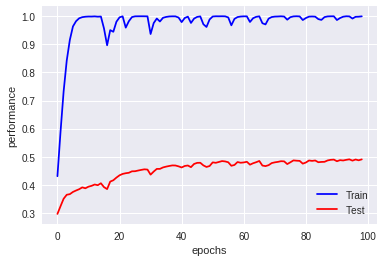

In [0]:
plt.xlabel('epochs')
plt.ylabel('performance')

train_list=np.mean(np.array(results_trains),axis=0)
test_list=np.mean(np.array(results_tests),axis=0)


plt.plot(range(epochs-1), train_list, 'b', label='Train')
plt.plot(range(epochs-1),test_list , 'r', label='Test')
plt.legend(loc='best')
plt.show()

In [0]:

images_test_raw = np.load('test_images.npy', encoding='latin1')
images_test=images_test_raw
images_test.shape






(10000, 2)

In [0]:
#cette partie refait entrainement sur 100% des donnes 
x_train = torch.from_numpy(np.array(inputX)).to(device)
y_train = torch.from_numpy(np.array(labelY) ).to(device)
from sklearn.utils import class_weight
#cette variable contient les poids pour blancer les classes
class_wg=class_weight.compute_class_weight('balanced',np.arange(31), np.array(labelY))
class_wg_tensor=torch.from_numpy(np.array(class_wg)).to(device)


model =MLPnet().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.5)
loss_fn = nn.CrossEntropyLoss(weight=class_wg_tensor)
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')
# data loading
train_loader=myDataset(x_train,y_train,transforms.Compose([        
        transforms.ToPILImage(),
        transforms.RandomAffine(0,scale=(0.87,1.1),shear=(-8,8)),
        transforms.RandomRotation((-20,20)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.5,],std=[0.5,]) 
        ]))
train_generator = torch.utils.data.DataLoader(train_loader, **params)
# training
for epoch in range(1, epochs):
    train(model, device, train_generator, optimizer, epoch, loss_fn)

RuntimeError: ignored

In [0]:
#cette partie fait les prediction sur l'ensembre de test
x_test_final =images_test[:,1]




inputPrimeX=[]
for i in range(x_test_final.shape[0]):
    temp=uber_cut(x_test_final[i].reshape(100,100)).flatten()
    #temp=x_test_final[i]
    inputPrimeX.append(np.array(temp.tolist()))#.reshape(1,100,100)
    
    
x_test_final = torch.from_numpy(np.array(inputPrimeX)).to(device)
paramsTestFinal = {'batch_size': 1,
          'shuffle': False}

final_test_loader=myDataset(x_test_final,x_test_final,transforms.Compose([        
        transforms.ToPILImage(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.5,],std=[0.5,]) 
        ]))
final_test_generator = torch.utils.data.DataLoader(final_test_loader, **paramsTestFinal)


pred_result=predict(model, device, final_test_generator)
print(pred_result)

In [0]:
#cette partie affiche les images et leur prediction, pour voir si le reseau donne des resultats
#qui on du sens
for i in range(100):
    image_ = (inputPrimeX[i]).reshape(32,32)
    plt.imshow(image_)
    plt.show() 
    print("pred: ",pred_result[i].tolist()[0],num_to_class( pred_result[i].tolist()[0] ) )
    print("^id^: ",i)


In [0]:
#imprime les donnes a copier/coller sur le fichier a remettre sur kaggle
print('Id,Category')
for i in range(10000):
    print(str(i)+','+str(num_to_class(pred_result[i].tolist()[0])) )
    
